In [0]:
# Code adapted from: Lars Nieradzik's code on Object Localization https://github.com/lars76/object-localization 
#    under MIT License

# Data: The Oxford-IIIT Pet Dataset http://www.robots.ox.ac.uk/~vgg/data/pets/ 
#    under Creative Commons License https://creativecommons.org/licenses/by-sa/4.0/

In [0]:
# IMPORT LIBRARIES AND PACKAGES

import csv
import math
import numpy as np
from PIL import Image

from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from tensorflow.keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from tensorflow.keras.backend import epsilon

In [0]:
# SETTINGS

ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_SIZE = 128 # Image sizes can vary (128, 160, 192, 224). MobileNetV2 can also take 96

EPOCHS = 5 # Number of epochs. I got decent performance with just 5.
BATCH_SIZE = 8 # Depends on your GPU or CPU RAM.
PATIENCE = 50 # Patience for early stopping

MULTI_PROCESSING = False # I have a 2 core computer without GPU
THREADS = 1 # I have a 2 core computer without GPU

In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
project_path = "/content/drive/My Drive/AIML Notes/BoundingBox/"

In [0]:
images_zip_path = project_path + "images.zip"

from zipfile import ZipFile

with ZipFile(images_zip_path, 'r') as z:
  z.extractall()

In [0]:
DATASET_FOLDER = "./images/"
TRAIN_CSV = project_path + "train.csv"
VALIDATION_CSV = project_path + "validation.csv"

In [0]:
# Training Data Generator

class DataSequence(Sequence):

    def __init__(self, csv_file):
        self.paths = []

        with open(csv_file, "r") as file:
            self.coords = np.zeros((sum(1 for line in file), 4))
            file.seek(0)

            reader = csv.reader(file, delimiter=",") # Read CSV file
            for index, row in enumerate(reader):
                for i, r in enumerate(row[1:7]): # Parse row with seven entities
                    row[i+1] = int(r)

                path, image_height, image_width, x0, y0, x1, y1, _, _ = row # Read image, its dimensions, BBox coords
                path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
                self.coords[index, 0] = x0 * IMAGE_SIZE / image_width # Normalize bounding box by image size
                self.coords[index, 1] = y0 * IMAGE_SIZE / image_height # Normalize bounding box by image size
                self.coords[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width # Normalize bounding box by image size
                self.coords[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height # Normalize bounding box by image size

                self.paths.append(path) # Read image from here

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)

    def __getitem__(self, idx): # Get a batch
        batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image path
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords

        batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        for i, f in enumerate(batch_paths):
            img = Image.open(f) # Read image
            img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
            img = img.convert('RGB')

            batch_images[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
            img.close()

        return batch_images, batch_coords

In [0]:
# A special validation function that computes Intersection-Over-Union (IOU), even though the loss is just for MSE of BBox coords

class Validation(Callback):
    def __init__(self, generator):
        self.generator = generator

    def on_epoch_end(self, epoch, logs):
        intersections = 0
        unions = 0

        for i in range(len(self.generator)):
            batch_images, gt = self.generator[i] # Get batch
            pred = self.model.predict_on_batch(batch_images) # Predict bbox on batch

            # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
            diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
            diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
            intersection = diff_width * diff_height

            # Compute union
            area_gt = gt[:,2] * gt[:,3]
            area_pred = pred[:,2] * pred[:,3]
            union = area_gt + area_pred - intersection

            # Compute intersection and union over multiple boxes
            for j, _ in enumerate(union):
                if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
                    intersections += intersection[j]
                    unions += union[j]

        # Compute IOU. Use epsilon to prevent division by zero
        iou = np.round(intersections / (unions + epsilon()), 4)
        logs["val_iou"] = iou

        print(" - val_iou: {}".format(iou))

In [0]:
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
    # Do not include classification (top) layer

    # to freeze layers, except the new top layer, of course, which will be added below
    for layer in model.layers:
        layer.trainable = trainable

    # Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
    x = model.layers[-1].output
    x = Conv2D(4, kernel_size=4, name="coords")(x)
    # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

    return Model(inputs=model.input, outputs=x)

In [0]:
model = create_model(False) # Arg is False, if you want to freeze lower layers for fast training (but low accuracy)
model.summary() # Print summary

train_datagen = DataSequence(TRAIN_CSV) # Generate training data batches
validation_datagen = Validation(generator=DataSequence(VALIDATION_CSV)) # Generate validation data batches

model.compile(loss="mean_squared_error", optimizer="adam", metrics=[]) # Regression loss is MSE

checkpoint = ModelCheckpoint("model-{val_iou:.2f}.h5", monitor="val_iou", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="max", period=1) # Checkpoint best validation model
stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max") # Stop early, if the validation error deteriorates
reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")
# Reduce learning rate if Validation IOU does not improve

model.fit_generator(generator=train_datagen,
                    epochs=EPOCHS,
                    callbacks=[validation_datagen, checkpoint, reduce_lr, stop],
                    workers=THREADS,
                    use_multiprocessing=MULTI_PROCESSING,
                    shuffle=True,
                    verbose=1)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv

In [0]:
# TESTING

import cv2
import numpy as np

from keras.applications.mobilenet import preprocess_input

Using TensorFlow backend.


In [0]:
# Load trained model for testing

WEIGHTS_FILE = "model-0.59.h5"

model = create_model()
model.load_weights(WEIGHTS_FILE)

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
# Pick a test image, run model, show image, and show predicted bounding box overlaid on the image

filename = './images/shiba_inu_163.jpg'

unscaled = cv2.imread(filename) # Original image for display



In [0]:
image_height, image_width, _ = unscaled.shape
image = cv2.resize(unscaled, (IMAGE_SIZE, IMAGE_SIZE)) # Rescaled image to run the network
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

In [0]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

In [0]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[0] + region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[1] + region[3]) * image_height / IMAGE_SIZE)

In [0]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

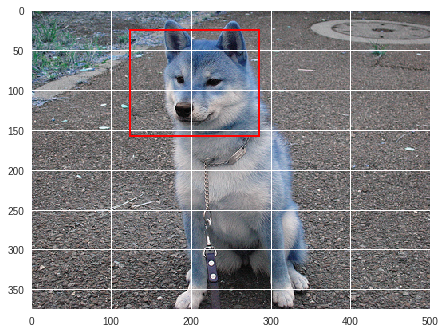

In [0]:
# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(unscaled)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()